In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from datetime import datetime, time
import seaborn as sns

In [3]:
from data.subjects_to_keep import subjects_to_keep as users
from data.data_path import data_path

1: 1
10: 2
2627: 3
2641: 4
2699: 5
6: 6
0: 7
101: 8
2974: 9
2861: 10
2459: 11
103: 12
2623: 13
2937: 14
77: 15
2455: 16
2685: 17
2644: 18
2616: 19
2672: 20
2733: 22
4507: 23
4610: 24
2740: 25
3392: 26
102: 28
4434: 33
82: 34
99: 35
2707: 38
2688: 42
2724: 44
2768: 47
2752: 53
2619: 54
4449: 65
2749: 73
4433: 108
4430: 111
4616: 140
4613: 141
4516: 145
1: 1
224: 2
254: 3
1928: 4
1121: 5
20: 6
14: 7
138: 8
106: 9
13: 10
113: 11
0: 12
6: 15
91: 17
1797: 18
36: 20
1773: 21
277: 23
1835: 24
97: 26
1866: 28
157: 31
1869: 36
218: 38
1856: 43
110: 44
236: 51
37: 52
115: 57
41: 59
311: 61
94: 63
216: 72
247: 80
240: 82
198: 98
135: 104
287: 105
178: 112
160: 124
1037: 3046
1: 1
3: 2
933: 4
428: 5
0: 6
2: 7
436: 8
22: 9
1118: 10
1014: 11
55: 12
80: 13
196: 15
36: 16
35: 17
52: 18
423: 19
887: 20
215: 23
424: 24
240: 25
1212: 27
54: 29
437: 30
506: 32
816: 33
1101: 34
53: 40
1114: 42
440: 46
429: 48
1173: 50
1007: 59
769: 69
513: 77
954: 102
454: 107
336: 177
350: 203
1: 1
11: 2
3442: 3
3414: 4
3

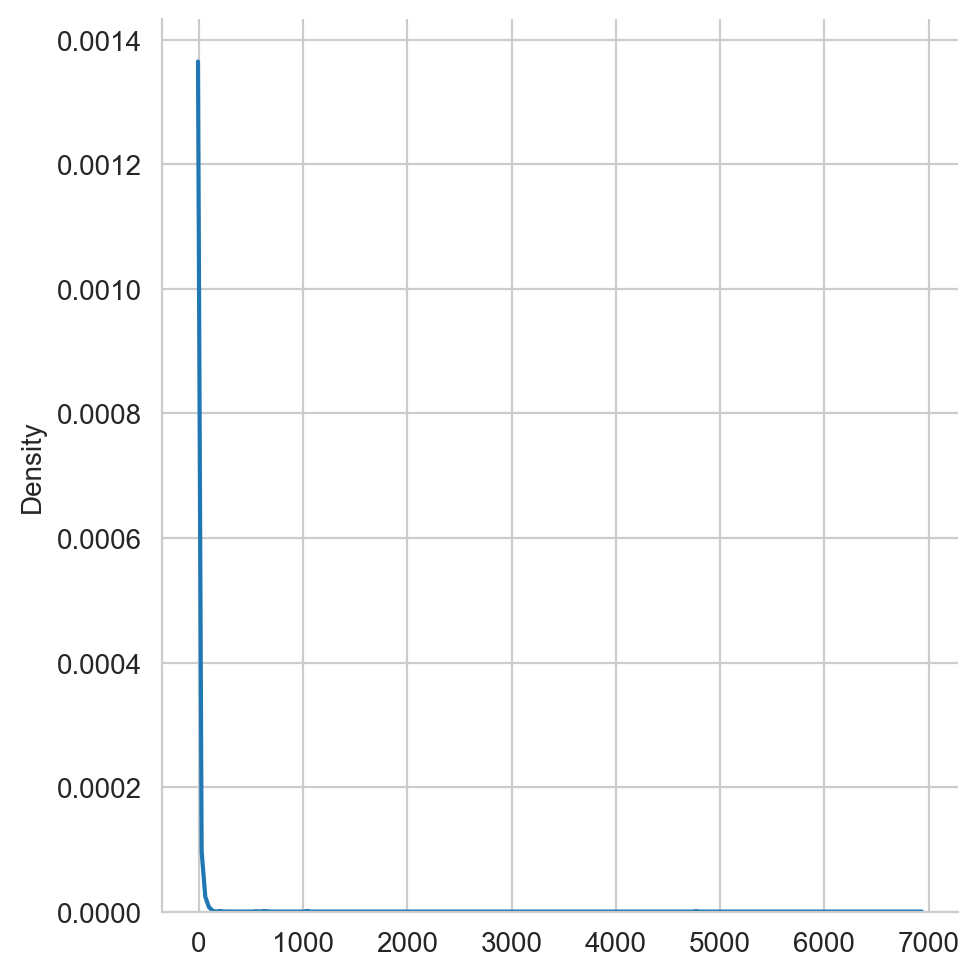

In [5]:
for u in users:  
    # u =  users[0] #"11KD" #"09AU"  "11KD"
    file = glob(f"{data_path}/dump_latest/{u}_activity*.csv")[0]
    #     print(f"Found the file `{file}`")
    
    df = pd.read_csv(file, index_col=0)
    df.dt = pd.to_datetime(df.dt, utc=False, format='ISO8601')
    df.dt = df.dt.dt.tz_convert('Europe/London')
    
    all_pos = df.step_midnight.values
    
    min_date = df.dt.min().date()
    days = np.asarray([(dt.date() - min_date).days for dt in df.dt])
    uniq_days = np.unique(days)
    all_timestep = (np.asarray([(dt - datetime.combine(dt, time.min, dt.tz)).total_seconds() for dt in df.dt]) / 86400)
    
    all_x = np.empty(shape=(0,))
    all_xdiff = np.empty(shape=(0,))
    all_ydiff = np.empty(shape=(0,))
    all_ydiff_raw = np.empty(shape=(0,))
    
    for day in uniq_days:
        
        is_day = days == day
        obs_timestep, obs_pos = all_timestep[is_day], all_pos[is_day]
        
        diff_obs_pos = np.diff(obs_pos)
        # uniq_diff_obs, indexes = np.unique(diff_obs_pos, return_index=True)
        # for idx, val in zip(indexes, uniq_diff_obs):
        #     print(f"{idx}: {uniq}")

        assert np.all(np.arange(obs_timestep.size) == np.argsort(obs_timestep)), "Not sorted"
        
        # Compute the diff
        xdiff = np.diff(obs_timestep)
        ydiff_raw = np.diff(obs_pos)
        ydiff = ydiff_raw / xdiff
        x = obs_pos[:-1]  # Forward approximation
        
        # y = np.sum(a <= x[:, None], axis=1)
        
        all_x = np.concatenate([all_x, x])
        all_xdiff = np.concatenate([all_xdiff, xdiff])
        all_ydiff = np.concatenate([all_ydiff, ydiff])

        all_ydiff_raw = np.concatenate([all_ydiff_raw, ydiff_raw])
    
    print(f"all_diff_raw min: {all_ydiff_raw.min()}, {all_ydiff_raw.max()}")
    sns.displot(all_ydiff_raw, kind="kde")
    unique, counts = np.unique(all_ydiff_raw, return_counts=True)
    for u, c in zip(unique, counts):
        print(f"{u}: {c} ({c/len(all_ydiff_raw):.5f})")
    # _mean = np.mean(all_xdiff)
    # _std = np.std(all_xdiff)
    # lw_bd = _mean - _std
    # up_bd = _mean + _std
    # to_exclude_because_x = (all_xdiff > up_bd) + (all_xdiff < lw_bd)
    # print(f"Prop excl: {np.sum(to_exclude_because_x)/to_exclude_because_x.size}")
    # 
    # _mean = np.mean(all_ydiff)
    # _std = np.std(all_ydiff)
    # lw_bd = _mean - _std
    # up_bd = _mean + _std
    # to_exclude_because_y = (all_ydiff > up_bd) + (all_ydiff < lw_bd)
    # print(to_exclude_because_y.shape)
    # print("bounds: ", lw_bd, up_bd)
    # print(f"Prop excl: {np.sum(to_exclude_because_y)/to_exclude_because_y.size}")
    # 
    # all_x = all_x[~(to_exclude_because_x+to_exclude_because_y)]
    # all_xdiff = all_xdiff[~(to_exclude_because_x+to_exclude_because_y)]
    # all_ydiff = all_ydiff[~(to_exclude_because_x+to_exclude_because_y)]
    
    #fig, ax = plt.subplots(figsize=(1.5, 1.5))
    #ax.scatter(all_x, all_ydiff, s=1, alpha=0.01)
    #ax.set_xscale("log")
    #ax.set_yscale("log")
    # plt.show()
    
    # idx = np.random.choice(np.arange(all_x.size), size=1000, replace=False)
    # all_x, all_ydiff = all_x[idx], all_ydiff[idx]
    # fig, ax = plt.subplots(figsize=(2, 2))
    # ax.scatter(all_x[idx], all_ydiff[idx], s=1, alpha=1)
    # ax.set_xlim(0, 13000)
    # print(np.median(all_ydiff[idx]))
    # ax.set_ylim(170000, 190000)
    
    #g = sns.jointplot(x=all_x[idx], y=all_ydiff[idx], kind="scatter") #, kind="hex", bins="log", gridsize=50)
    #g.ax_joint.set_yscale('log')
    break


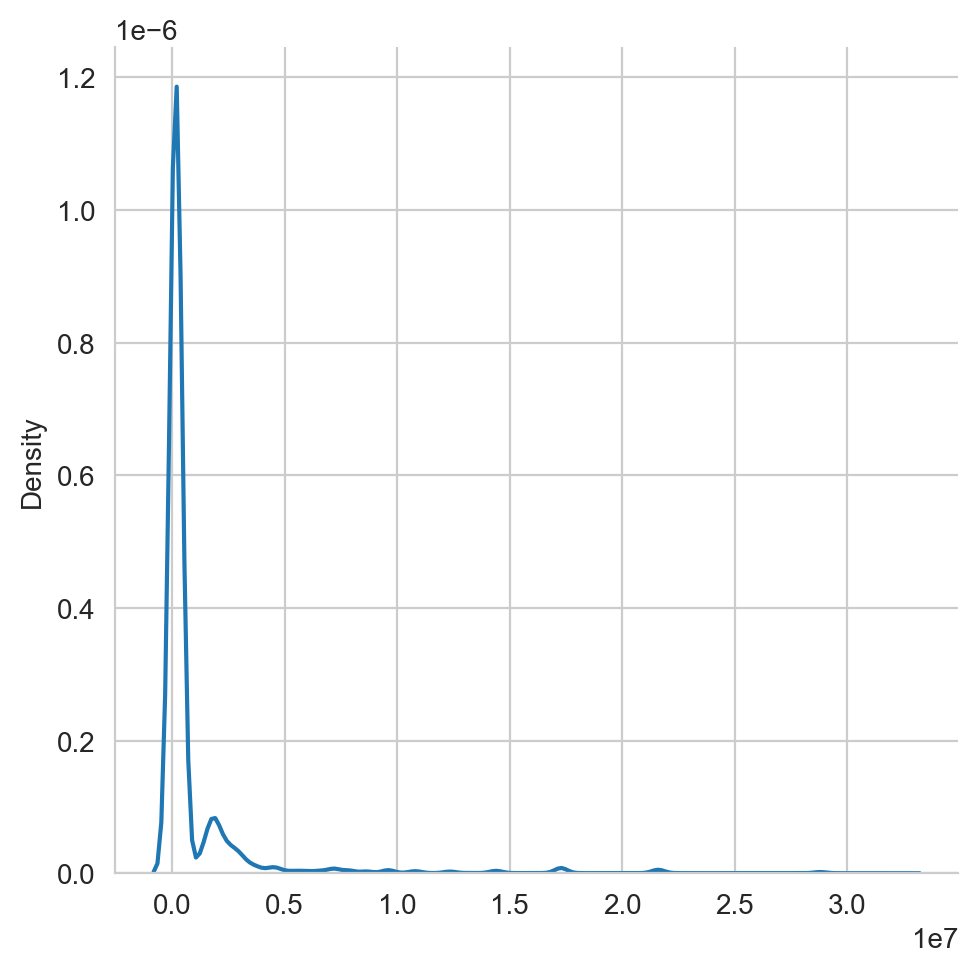

In [6]:
sns.displot(all_ydiff, kind="kde")

In [38]:
np.min(all_xdiff)*86400, np.max(all_xdiff)*86400, np.mean(all_xdiff)*86400, np.std(all_xdiff)*86400

(0.001999999992818857, 58813.927, 5.830543618324466, 300.43918940882384)

In [39]:
300/60

5.0

In [40]:
np.sum(all_xdiff>np.mean(all_xdiff)+3*np.std(all_xdiff))/all_xdiff.size

0.0007200366564115991

In [5]:
alpha_tpvv = np.zeros((n_timestep, n_position, n_velocity, n_velocity))

NameError: name 'n_timestep' is not defined

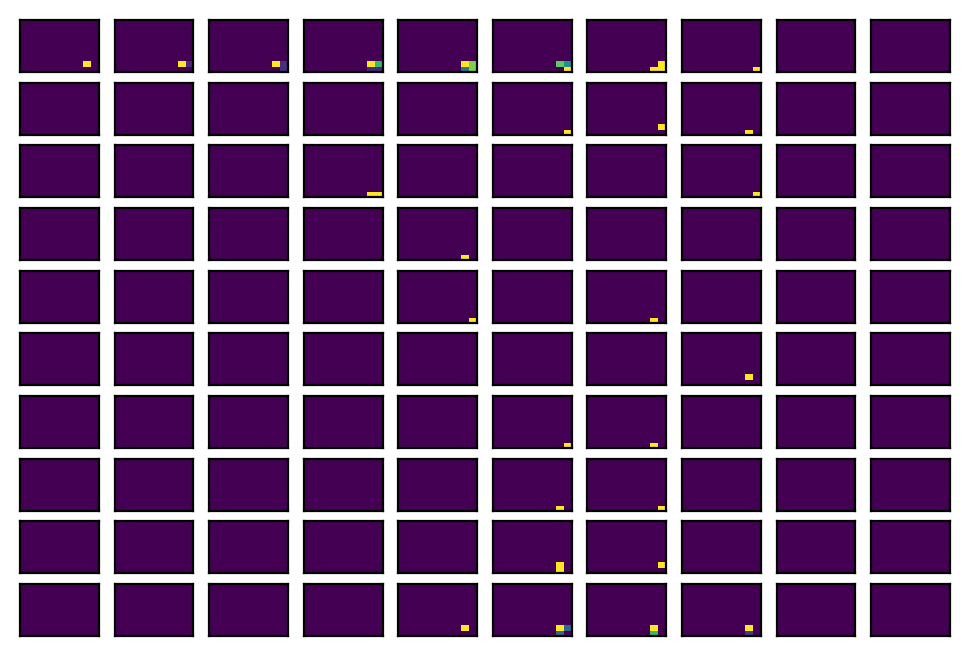

In [133]:
fig, axes = plt.subplots(
                nrows=n_position,
                ncols=n_timestep,
                figsize=(6, 4))
for t_idx in range(n_timestep):
    for p_idx in range(n_position):
        ax = axes[p_idx, t_idx]
        img = alpha_tpvv[t_idx, p_idx, :, :]
        ax.imshow(img, aspect="auto")
        ax.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
plt.show()

In [9]:
position = np.linspace(0, 7000, 10)
velocity = np.linspace(-50000, 5000, 10)
timestep = np.linspace(0, 1, 10)
dp = position[1] - position[0]
dt = timestep[1] - timestep[0]
dv = velocity[1] - velocity[0]
n_timestep = timestep.size
n_position = position.size
n_velocity = velocity.size

Think about:
- removing the data points when there is no change in position
- adding a data point at the beginning of the day with position 0, and a data point at the end of the day with last observed position 
